In [1]:
from importlib import reload
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary

# %load_ext tensorboard

from smlm_dl import dataset, model, trainer, util
import numpy as np
import skimage

d:\github\smlm-dl\smlm_dl\dataset.py:423: RuntimeWarning: invalid value encountered in log
  im = axes[1].imshow(np.log(tiled_images))


18:	 [id = 18.000,], [A = 1498.465, 625.329, 1947.759, 1924.935, 1968.688, 878.907,], [bg = 80.549,], [x = 8.567, -2.215, -3.789, 4.096, -15.748, 8.981,], [y = 12.165, -5.251, 5.412, -9.027, 15.562, 11.744,], [z = 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,],
38:	 [id = 38.000,], [A = 1876.818, 1452.035, 1257.713, 1920.753, 966.948, 1915.807,], [bg = 37.204,], [x = -0.786, -10.288, -2.321, -4.408, 13.102, 6.748,], [y = -7.876, 5.028, 7.533, 2.396, 1.123, -0.624,], [z = 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,],
108:	 [id = 108.000,], [A = 518.750, 1290.509, 1441.960, 1963.008, 1191.758, 775.780,], [bg = 73.025,], [x = 8.912, 4.302, 5.910, 10.933, 5.169, 0.390,], [y = 10.370, 12.603, -4.035, 9.401, 6.971, 13.405,], [z = 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,],
10:	 [id = 10.000,], [A = 592.771, 502.160, 1587.102, 1218.806, 1566.742, 1435.824,], [bg = 71.269,], [x = 9.256, -2.588, 15.246, 6.923, 8.796, -3.459,], [y = 4.376, -13.935, 4.445, 13.258, -6.107, 8.639,], [z = 0.000, 0.000, 0.

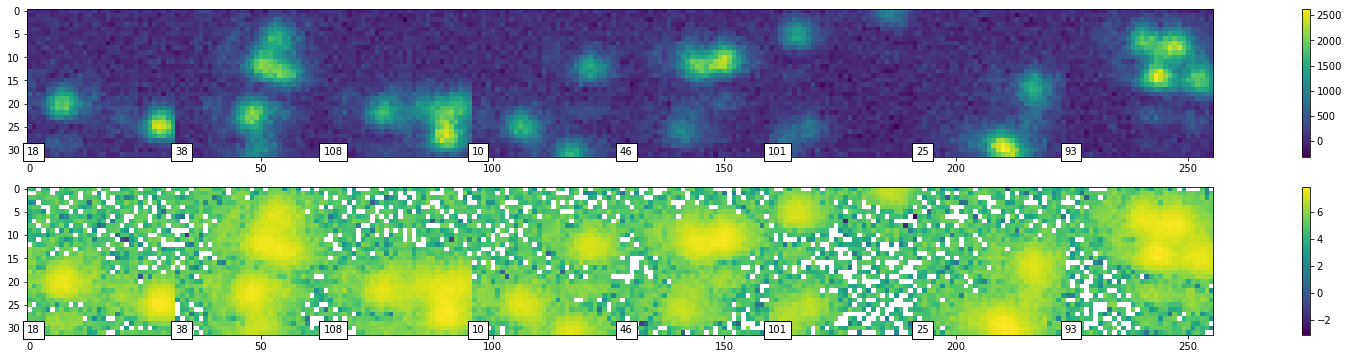

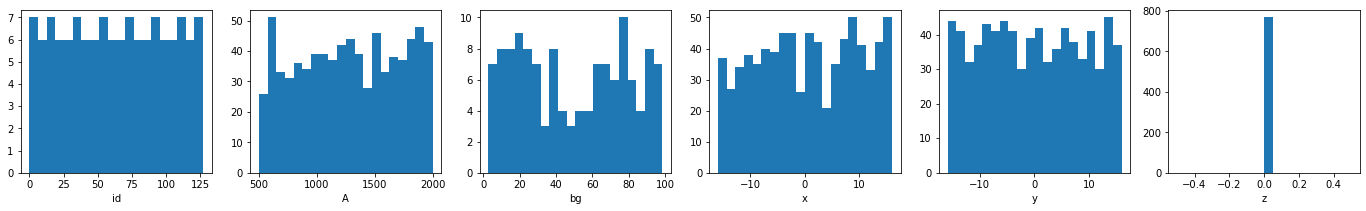

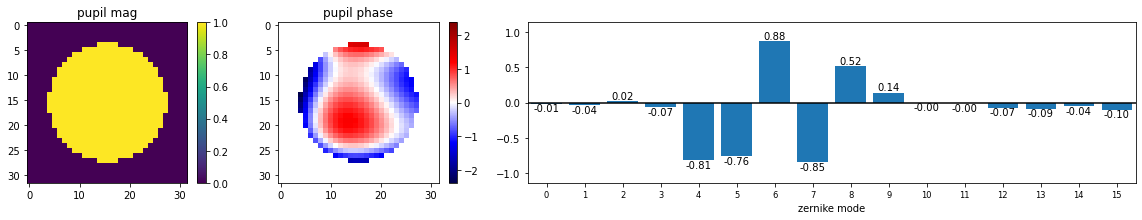

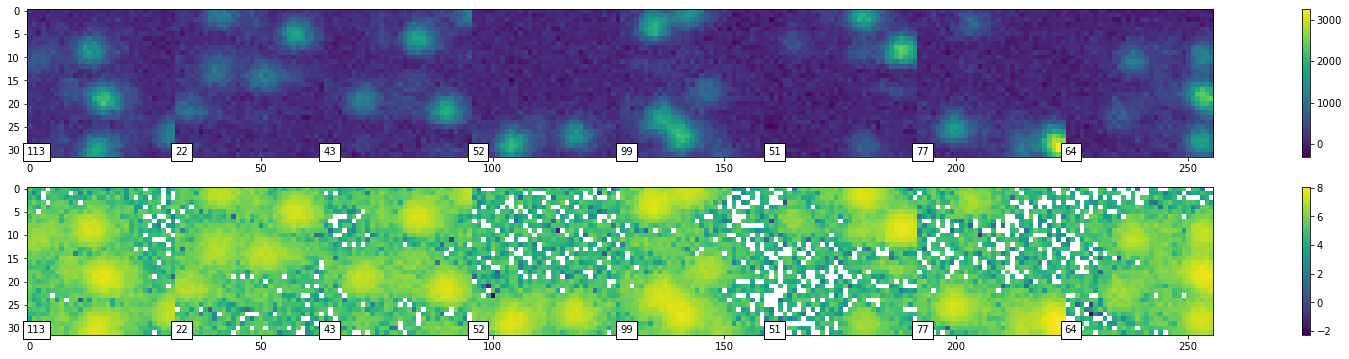

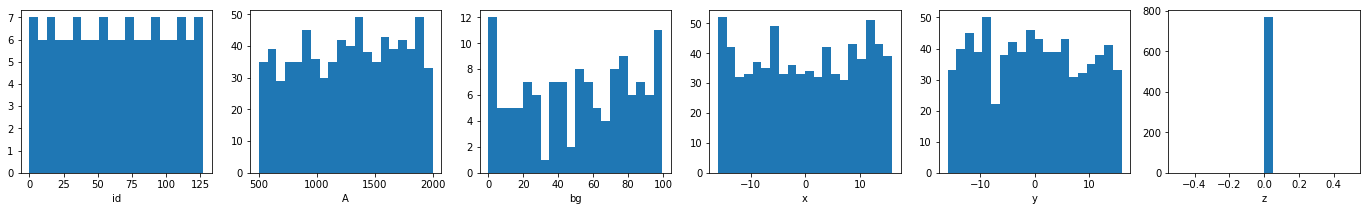

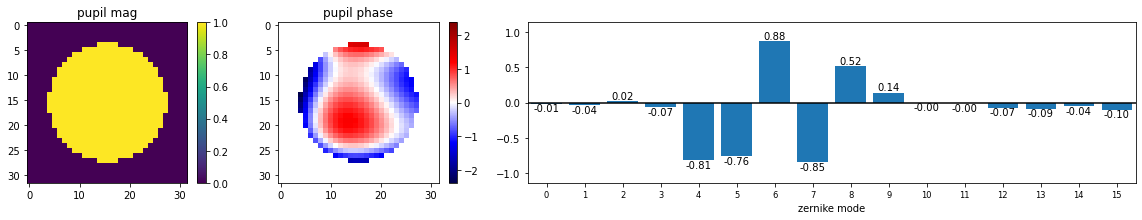

In [2]:
reload(dataset)

settings = {
    'out_size': (32,32),
    'length': (128, 6),
    'dropout_p':0.25,
    'psf_params': {'A': [500, 2000],
                     'bg': [0, 100],
                     'x': [-16, 16],
                     'y': [-16, 16],
                    },
    'psf_zerns': {key: np.random.uniform(-1,1) for key in range(3, 10)},
    'augmentations': {},
    'normalize': False
}

training_data = dataset.FourierOpticsPSFDataset(**settings)
dataset.inspect_images(training_data)
train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True)


valid_data = dataset.FourierOpticsPSFDataset(**settings)
dataset.inspect_images(valid_data)
valid_dataloader = DataLoader(valid_data, batch_size=128, shuffle=True)

C:\Users\Kenny\anaconda3\envs\smlm-dl\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


CUDA not available. Defaulting to CPU
Device: cpu
Layer (type (var_name))                       Output Shape              Param #
BaseFitModel                                  --                        --
├─UnetEncoderModel (encoder)                  [8, 11, 32, 32]           --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [8, 32, 32, 32]           --
│    │    │    └─Conv2d (0)                   [8, 32, 32, 32]           320
│    │    │    └─ReLU (1)                     [8, 32, 32, 32]           --
│    │    │    └─Conv2d (2)                   [8, 32, 32, 32]           9,248
│    │    │    └─ReLU (3)                     [8, 32, 32, 32]           --
│    │    └─Sequential (pool_layer0)          [8, 32, 16, 16]           --
│    │    │    └─Dropout2d (0)                [8, 32, 32, 32]           --
│    │    │    └─MaxPool2d (1)                [8, 32, 16, 16]           --
│    │    └─Sequential (conv_layer1)     

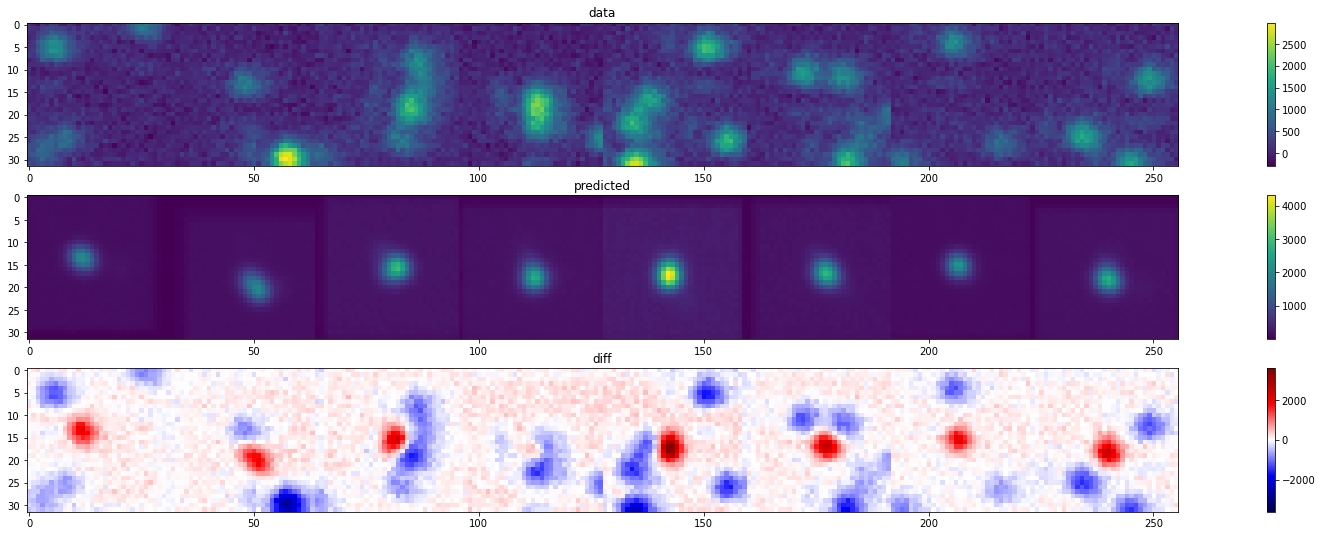

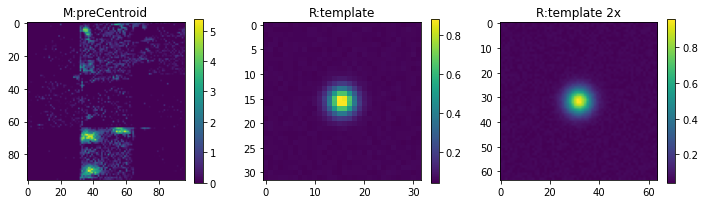

In [ ]:
reload(trainer)
reload(model)

params_ref_override = {
            'x': model.FitParameter(nn.Hardtanh(), 0, 20, 0, True),
            'y': model.FitParameter(nn.Hardtanh(), 0, 20, 0, True),
            'A': model.FitParameter(nn.ReLU(), 0., 2000, 1, True),
            'bg': model.FitParameter(nn.Tanh(), 0, 200, 0, False),
}

fitting_model = model.BaseFitModel(renderer_class=model.renderer.Template2DRenderer,
                                   # encoder_class=model.ConvImageEncoderModel,
                                   encoder_class=model.UnetEncoderModel,
                                   # mapper_class=model.mapper.DirectMapperModel,
                                   mapper_class=model.mapper.CentroidMapperModel,
                                   img_size=(32,32),
                                   max_psf_count=10,
                                   fit_params=['x','y','bg','A'],
                                   encoder_params={
                                          # "num_img":len(training_data),
                                          "depth":4,
                                          "first_layer_out_channels":32,
                                          # "skip_channels":16,
                                                     # "init_weights":init_params
                                                     },
                                   # params_ref_override=params_ref_override,
)
                                    # params_ref_no_scale=True)

optimizer = torch.optim.AdamW(fitting_model.parameters(), lr=5e-4)

training = trainer.FittingTrainer(fitting_model, train_dataloader, valid_dataloader, optimizer=optimizer)

# training.train_and_validate(2,)
print(summary(fitting_model, input_size=(8, 1, 32, 32), row_settings=["var_names"], depth=4))
model.check_model(fitting_model, train_dataloader)

In [ ]:
print(training.model.mapped_params.keys())

In [ ]:
training.train_and_validate(2, training_interval=1, validate_interval=10, label="multiemitter_test", tb_log_limit_images=8)

In [ ]:
model.check_model(fitting_model, train_dataloader)